# Logistic regression

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

Implement a function that returns the linear prediction for the log of the odds ratio. It should include the bias term. `X` is a $n_d\times n_f$ array of data: $n_d$ samples with each $n_f$ features. `w` is a $n_f+1$ vector of parameters. We want the function to return a $n_d$ dimanesional vector with each component $z^{(i)}$ satisfying 

$$ z^{(i)} = w_0 +\sum_{j=1}^{n_f} w_j x_j^{(i)}\;.$$

In [2]:
def z(X,w):
    nd, nf = X.shape
    Xaug = np.empty((nd, nf + 1))
    Xaug[:,0] = np.ones( (nd))
    Xaug[:,1:] = X
                
    return np.dot(Xaug,w)


This tests your code:

In [3]:
Xtest = np.array([[1,2],[2,4],[3,6]])
ytest = np.array([0,0,1])
wtest = np.array([7,0,0])
assert isinstance(z(Xtest,wtest), (list, tuple, np.ndarray)), 'Return value should be an array/list/tuple'
assert (z(Xtest,wtest) == np.array([7,7,7])).all()
wtest = np.array([7,-2,1])
assert (z(Xtest,wtest) == np.array([7,7,7])).all()
wtest = np.array([7,10,1])
assert (z(Xtest,wtest) == np.array([19,31,43])).all()

Implement the sigmoid function:

In [4]:
def phi(z):
    return 1.0/(1+np.exp(-z))


Test your answer:

In [5]:
assert phi(0)==0.5
assert np.isclose(phi(np.linspace(-2,2,10)),np.array([0.11920292, 0.17428532, 0.2476638 , 0.33924363, 0.44467194,
       0.55532806, 0.66075637, 0.7523362 , 0.82571468, 0.88079708])).all()

Implement a function that returns the prediction for data $X$ and parameter vector $w$

In [6]:
def predict(X,w):
    Z = z(X,w)
    return phi(Z)

Test your implementation:

In [7]:
Xtest = np.array([[1,-3],[2,-4],[3,6]])
wtest = np.array([0.01,0.01,0.01])
assert isinstance(predict(Xtest,wtest), (list, tuple, np.ndarray)), 'Return value for this test should be an array/list/tuple'
assert isinstance(predict(Xtest,wtest)[0], float), 'Return value should be a list of floats.'
assert np.isclose(predict(Xtest,wtest),np.array([0.49750002, 0.49750002, 0.52497919])).all()

Define the cross entropy loss function for data $X$, label $y$ and parameter $w$.

In [8]:
def J(X,y,w):
    pred = predict(X, w)
    eps = 1e-10
    pred = np.clip(pred,eps, 1-eps)
    return - np.sum( y*np.log(pred) + (1-y)*np.log(1-pred))


Test your implementation:

In [9]:
Xtest = np.array([[1,-3],[2,-4],[3,6]])
ytest = np.array([0,0,1])
wtest = np.array([0.01,0.01,0.01])
assert isinstance(J(Xtest, ytest, wtest), float), 'Return value should be a float.'
assert np.isclose(J(Xtest, ytest, wtest), 2.020716021089296)

For fitting the model we need gradient of the loss function. Implement it here:

In [10]:
def gradJ(X,y,w):
    nd, nf = X.shape
    Xaug = np.empty((nd, nf + 1))
    Xaug[:,0] = np.ones( (nd))
    Xaug[:,1:] = X
    return -  np.dot( (y-predict(X,w)),  Xaug)


Test your code:

In [11]:
Xtest = np.array([[1,-3],[2,-4],[3,6]])
ytest = np.array([0,0,1])
wtest = np.array([0.01,0.01,0.01])

assert isinstance(gradJ(Xtest,ytest,wtest), (list, tuple, np.ndarray)), 'Return value for this test should be an array/list/tuple'
assert isinstance(gradJ(Xtest,ytest,wtest)[0], float), 'Return value should be a list of floats.'

assert np.isclose(gradJ(Xtest,ytest,wtest), np.array([ 0.51997923,  0.06743762, -6.33262502])).all()

We can also test numerically that we got the gradient right:

In [12]:
delta = 0.00001
Jp0 = J(Xtest,ytest,wtest+[delta,0,0])
Jp1 = J(Xtest,ytest,wtest+[0,delta,0])
Jp2 = J(Xtest,ytest,wtest+[0,0,delta])
J0 = J(Xtest,ytest,wtest)
g0 = (Jp0-J0)/delta
g1 = (Jp1-J0)/delta
g2 = (Jp2-J0)/delta
assert np.isclose( gradJ(Xtest,ytest,wtest), [g0, g1, g2], rtol=1e-3).all()

We also need a function to calculate the score, that is the ratio of correctly predicted values to the total number of values predicted. 

In [13]:
def getScore(X,y,w):
    p = (predict(X,w) > 0.5)
    success = (p.astype(int) == y)
    return np.count_nonzero( success )/X.shape[0]   


In [14]:
Xtest = np.array([[1,-3],[2,-4],[3,6]])
ytest = np.array([0,0,1])
wtest = np.array([0.01,0.01,0.01])
assert getScore(Xtest, ytest, wtest) == 1.0
ytest = np.array([0,1,1])
assert getScore(Xtest, ytest, wtest) == 2.0/3.0
ytest = np.array([1,1,1])
assert getScore(Xtest, ytest, wtest) == 1.0/3.0

## Learning code

Define the function `learn` that takes the data `X`, the target `y`, the learning rate `eta` and the number of steps `nsteps` as arguments and returns the three vectors:
 - the value of the parameters after each step (including before the first step)
 - the value of the loss at each step
 - the value of the score at each step

Start from randomly initialized parameters in the range $[0, \, 1]$.

In [15]:
def learn(X,y,eta, nsteps):
    
    random.seed(1243)
    
    w0 = [random.random(),random.random(),random.random()]
    
    ws = np.empty( (nsteps+1,3) )
    ws[0] = np.array(w0)
    
    js = np.empty( nsteps+1 )
    js[0] = J(X,y,ws[0])
    
    scores = np.empty( nsteps+1 )
    scores[0] = getScore(X,y,w0)
    
    for i in range(nsteps):
        g = gradJ(X,y,ws[i])
        ws[i+1] = ws[i] - eta * g
        js[i+1] = J(X,y,ws[i+1])
        scores[i+1] = getScore(X,y,ws[i+1])  
    return ws, js, scores


This function will show you plots for the learning of your algorithm if you provide the above mentionned vectors.

In [16]:
def makePlots(ws, js, scores):
    plt.figure(figsize=(15,10))
    plt.subplot(221)
    plt.plot(ws[:,0])
    plt.plot(ws[:,1])
    plt.plot(ws[:,2])
    plt.title("Parameters")
    
    plt.subplot(222)
    
    plt.plot(js)
    plt.yscale('log')
    plt.title('loss')
    
    plt.subplot(223)
    plt.plot(scores)
    plt.title('scores')

## Cancer data

We start we a dataset of benign and malignent cancer cases. We only look at two features.

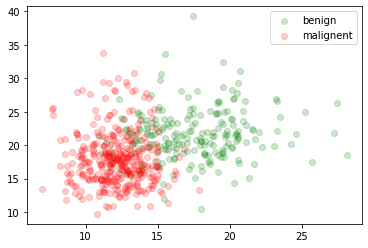

In [17]:
from sklearn import datasets
cancer = datasets.load_breast_cancer()
#only take two features
X = cancer.data[:,:2]
y = cancer.target
malignent = cancer.data[y==1]
benign = cancer.data[y==0]
xb, yb = benign[:,0],benign[:,1]
xm, ym = malignent[:,0],malignent[:,1]
plt.scatter(xb,yb,color='g',alpha=0.2,label='benign')
plt.scatter(xm,ym,color='r',alpha=0.2,label='malignent')
plt.legend();

Here we normalise the features before learning.

In [18]:
Xunscaled = np.array(X)
av = np.average(X,axis=0)
sc = np.std(X,axis=0)
X = (X-av)/sc

Experiment with different learning rates and number of steps! Try without normalising the features.

With a reasonable learning rate the parameter converge to a fixed value and the loss and score stablize. 

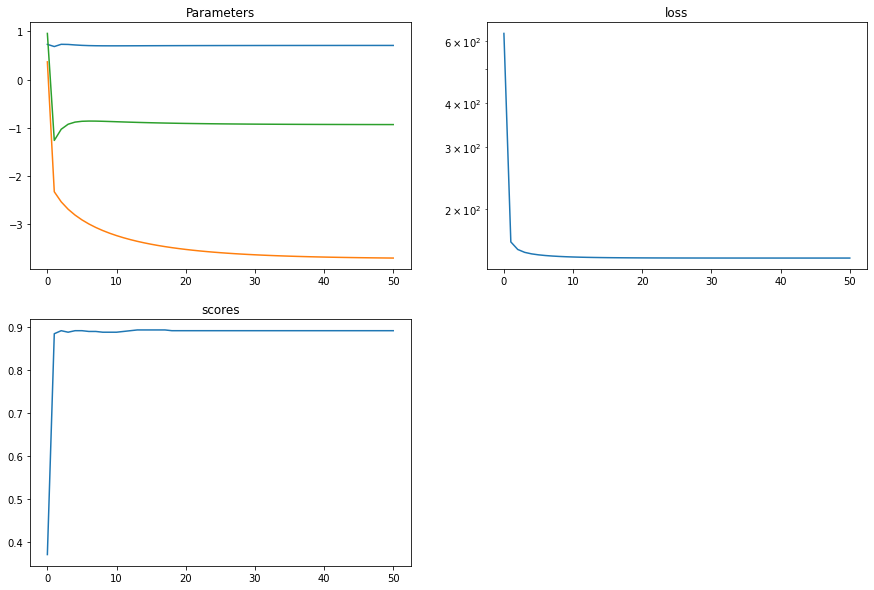

In [19]:
ws, js, scores = learn(X, y, eta= 0.01, nsteps = 50)
makePlots(ws, js, scores)

With a too large learning rate the solution is unstable.

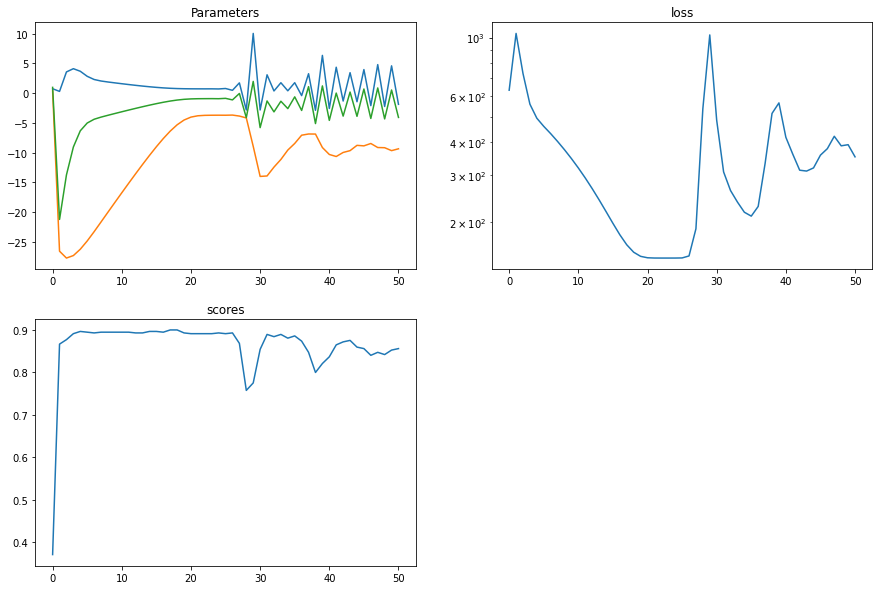

In [20]:
ws, js, scores = learn(X, y, eta= 0.1, nsteps = 50)
makePlots(ws, js, scores)

With a too small learning rate it takes longer to get to the best value of the parameters. 

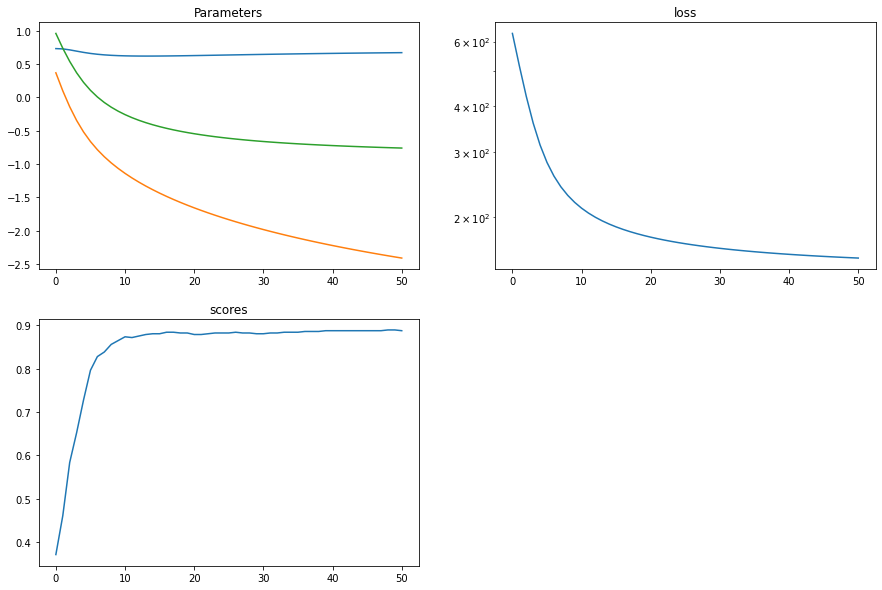

In [21]:
ws, js, scores = learn(X, y, eta= 0.001, nsteps = 50)
makePlots(ws, js, scores)

Without normalising the inputs we don't get a stable result with the reasonable learning rate we used before.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


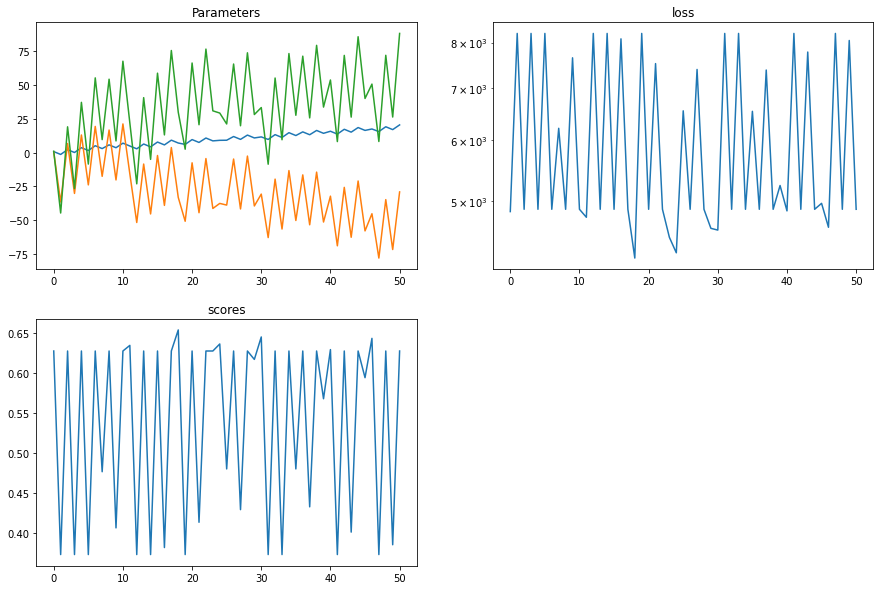

In [22]:
ws, js, scores = learn(Xunscaled, y, eta= 0.01, nsteps = 50)
makePlots(ws, js, scores)

We can get a reasonable convergence for a much smaller learning rate.

[ 0.85368297 -0.20529638  0.12218673]


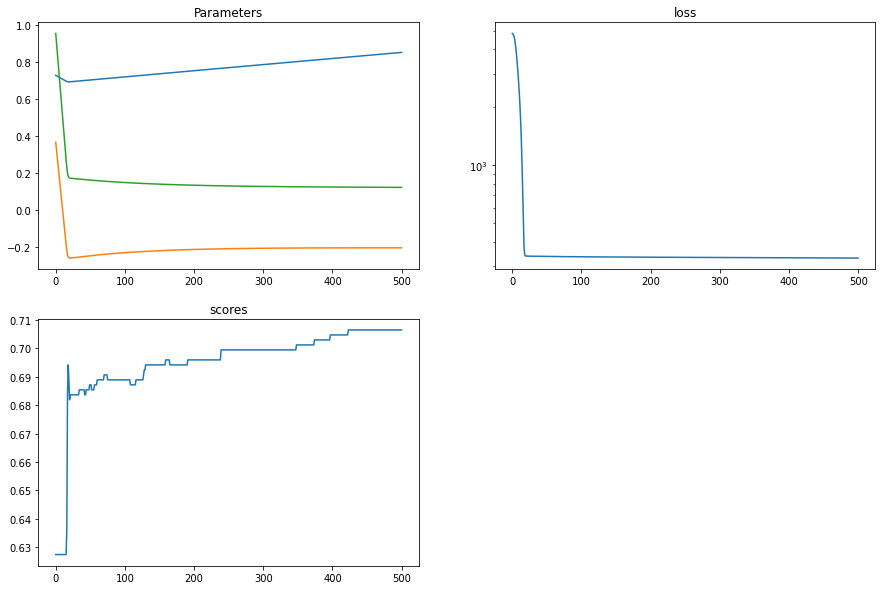

In [23]:
ws, js, scores = learn(Xunscaled, y, eta= 0.00001, nsteps = 500)
makePlots(ws, js, scores)
print(ws[-1])

The problem is that the initial weights are too big, they are of order 1 and our features of order ~20. So the arguments of the sigmoid function become very large. 

## Iris dataset

Here we use a different data set. This time the data is linearly separable. What is different? Is the decision boundary better than with the perceptron algorithm?

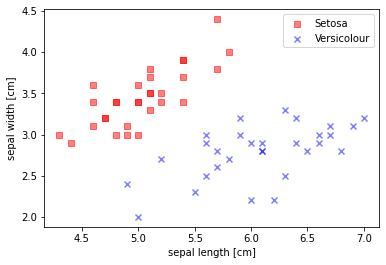

In [24]:
from sklearn import datasets
data_dic = datasets.load_iris()
features = data_dic['data']
targets = data_dic['target']

c1 = features[targets==0]
c2 = features[targets==1]
c3 = features[targets==2]


def subSample(nData):
    X = np.empty((2*nData,2))
    X[:nData] = c1[:nData,:2]
    X[nData:] = c2[:nData,:2]
    Y = np.empty(2*nData)
    Y[:nData] = np.ones(nData)
    Y[nData:] = np.zeros(nData)
    return X,Y

nData = 30
X, Y = subSample(nData)

# plot

X[Y==0]
c1 = X[Y==1]
c2 = X[Y==0]
plt.scatter(c1[:,0],c1[:,1], color='red', marker='s', alpha=0.5, label="Setosa")
plt.scatter(c2[:,0],c2[:,1], color='blue', marker='x', alpha=0.5, label="Versicolour")
plt.legend()
plt.xlabel("sepal length [cm]")
plt.ylabel("sepal width [cm]");



Experiment with different step numbers and learning rates.

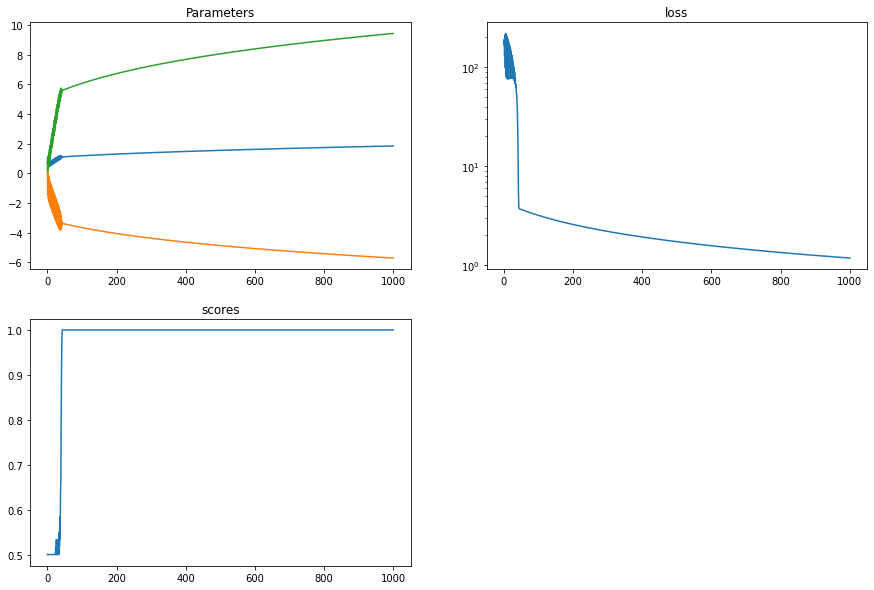

In [25]:
ws, js, scores = learn(X, Y, eta= 0.01, nsteps = 1000)
makePlots(ws, js, scores)

Does it make a difference to normalise the features? Do the parameters stabilize to a given value? Can you explain why?

If the data is linearly separable and you have parameter $w$ that give a valid decision line, then scaling all parameters by a common factor will improve the loss. This means making harsher and harsher decision around the boundary. This means the model is less likely to generalise well. Adding a penalisation term to the loss would limit the size of the parameters to preven overfitting.    